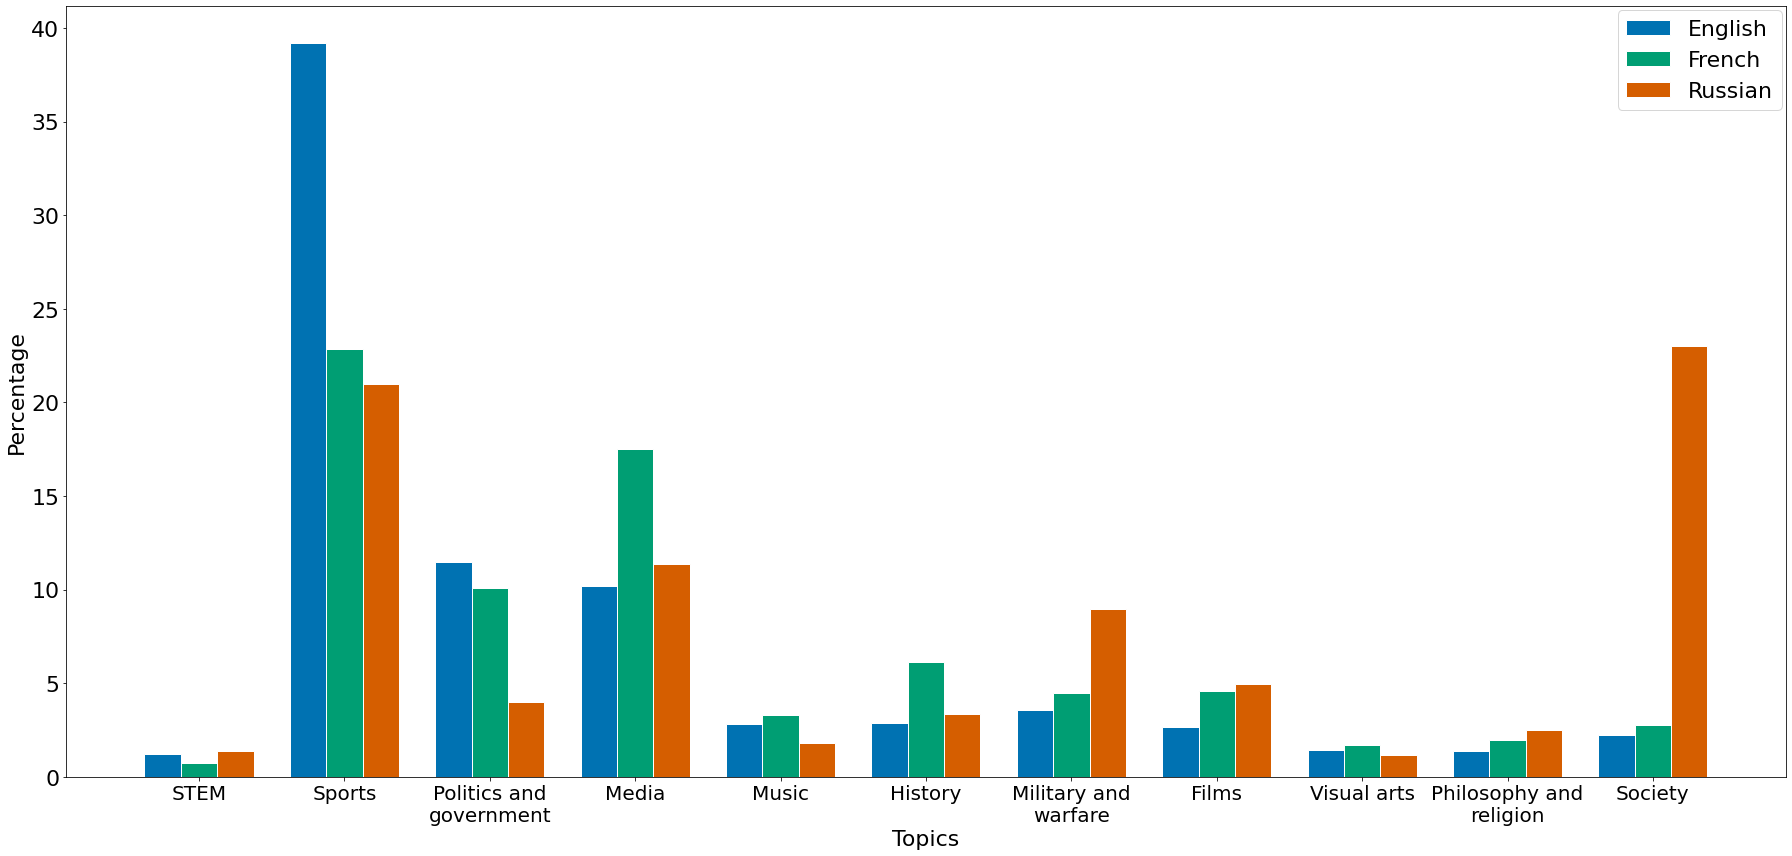

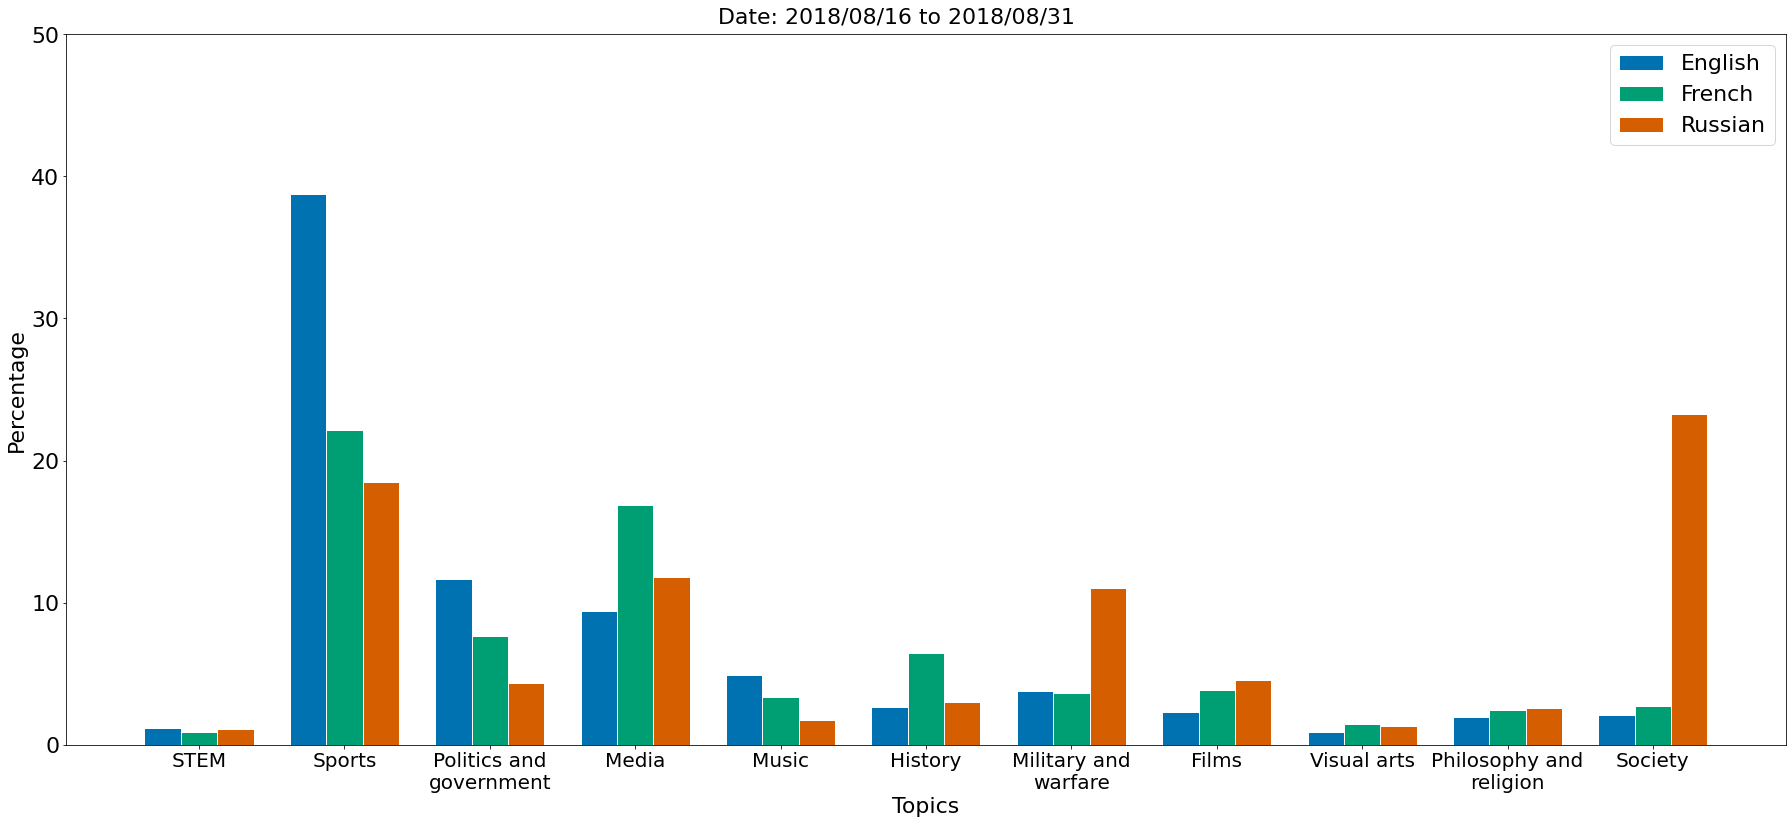

In [10]:
import IPython
import numpy as np
import networkx as nx
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import time
import community
from fonctions import *
from pylab import rcParams


### Layout parameters
plt.style.use('seaborn-colorblind')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['figure.figsize'] = 25, 12
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 22


### Variables for the following pipeline

pd.set_option('mode.chained_assignment', None)

path_en = 'Results/EN/EN_'
path_fr = 'Results/FR/FR_'
path_ru = 'Results/RU/RU_'

list_date = ['20180816_20180831', '20180901_20180915', '20180916_20180930', '20181001_20181015', 
            '20181016_20181031', '20181101_20181115',  '20181116_20181130', '20181201_20181215',
            '20181216_20181231']

# list_date = ['20191217_20191231', '20200101_20200115', '20200116_20200131', '20200201_20200215',
#              '20200216_20200229', '20200301_20200315', '20200316_20200331','20200401_20200415',
#              '20200416_20200430']

list_topic = ['STEM*', 'Sports', 'Politics_and_government', 'Media*', 'Music', 'History', 'Military_and_warfare',
             'Films', 'Visual_arts*', 'Philosophy_and_religion', 'Society']




def count_topics(date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    

    df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
    df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
    df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

    count_en = df_en[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_fr = df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_ru = df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum()

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)





def count_total_topics(list_date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    for date in list_date:
            
        df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
        df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
        df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

        count_en = count_en.add(df_en[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_fr = count_fr.add(df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_ru = count_ru.add(df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)
    

    

def display_topics_comparison(ratio_en, ratio_fr, ratio_ru, list_topic):
    fig = plt.figure()

    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars_en, bars_fr, bars_ru = [], [], []

    for tp in list_topic:
        bars_en.append(list(ratio_en.loc[ratio_en.index.str.contains(tp)])[0])
        bars_fr.append(list(ratio_fr.loc[ratio_fr.index.str.contains(tp)])[0])
        bars_ru.append(list(ratio_ru.loc[ratio_ru.index.str.contains(tp)])[0])

    # Set position of bar on X axis
    r1 = np.arange(len(bars_en))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]


    
    plt.bar(r1, bars_en, width=barWidth, edgecolor='white', label='English')
    plt.bar(r2, bars_fr, width=barWidth, edgecolor='white', label='French')
    plt.bar(r3, bars_ru, width=barWidth, edgecolor='white', label='Russian')

    # Add xticks on the middle of the group bars
    
    
    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
    l_topic[2]=l_topic[2][0:12] + '\n' + l_topic[2][13:]
    l_topic[6]=l_topic[6][0:12] + '\n' + l_topic[6][13:]
    l_topic[9]=l_topic[9][0:14] + '\n' + l_topic[9][15:]
    
    plt.xticks([r + barWidth for r in range(len(bars_en))], l_topic, rotation='horizontal')
    
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    
    
    fig.tight_layout()
    # Create legend & Show graphic
    fig.legend(fontsize=22)
    plt.show()
    fig.savefig("Figures_comparison/topic_distribution.pdf", bbox_inches='tight')
    
    

def barlist(n): 
    bars_en, bars_fr, bars_ru = [], [], []
    df_en, df_fr, df_ru = count_topics(list_date[n])
    for tp in list_topic:
        bars_en.append(list(df_en.loc[df_en.index.str.contains(tp), 'Ratio'].values)[0])
        bars_fr.append(list(df_fr.loc[df_fr.index.str.contains(tp), 'Ratio'].values)[0])
        bars_ru.append(list(df_ru.loc[df_ru.index.str.contains(tp), 'Ratio'].values)[0])
    return bars_en, bars_fr, bars_ru    
    
    
    
def topic_evolution(list_topic, list_date):
    fig= plt.figure()
    barWidth = 0.25
    
    ax=plt.axes()
    ax.set_ylim(0, 50)
    
    n=len(list_date) #Number of frames
    
    bar_en, bar_fr, bar_ru = barlist(0)
    
    r1=range(len(bar_en))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    barcollection_en = plt.bar(r1, bar_en, width=barWidth, edgecolor='white', label='English')
    barcollection_fr = plt.bar(r2, bar_fr, width=barWidth, edgecolor='white', label='French')
    barcollection_ru = plt.bar(r3, bar_ru, width=barWidth, edgecolor='white', label='Russian')
    
    # Making date more readable 
    date_title = []
    for date in list_date:
        date_title.append(date[0:4]+'/'+date[4:6]+'/'+date[6:8]+' to '+date[9:13]+'/'+date[13:15]+'/'+date[15:17])

    def animate(i):
        y_en, y_fr, y_ru = barlist(i)
        fig.suptitle('Date: ' + date_title[i], fontsize=22)
        for n, b in enumerate(barcollection_en):
            b.set_height(y_en[n])
        for n, b in enumerate(barcollection_fr):
            b.set_height(y_fr[n])
        for n, b in enumerate(barcollection_ru):
            b.set_height(y_ru[n])
        
    anim=FuncAnimation(fig, animate, repeat=True, blit=False, frames=n, interval=1000)
    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
    l_topic[2]=l_topic[2][0:12] + '\n' + l_topic[2][13:]
    l_topic[6]=l_topic[6][0:12] + '\n' + l_topic[6][13:]
    l_topic[9]=l_topic[9][0:14] + '\n' + l_topic[9][15:]
    
    plt.xticks([r + barWidth for r in range(len(list_topic))], l_topic, rotation='horizontal')
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.legend(fontsize=22)
    plt.show()
    anim.save('Figures_comparison/bar.gif', writer='pillow')
    

    


    
count_en, count_fr, count_ru = count_total_topics(list_date)

display_topics_comparison(count_en['Ratio'], count_fr['Ratio'], count_ru['Ratio'], list_topic)

topic_evolution(list_topic, list_date)    

<Figure size 1800x864 with 0 Axes>

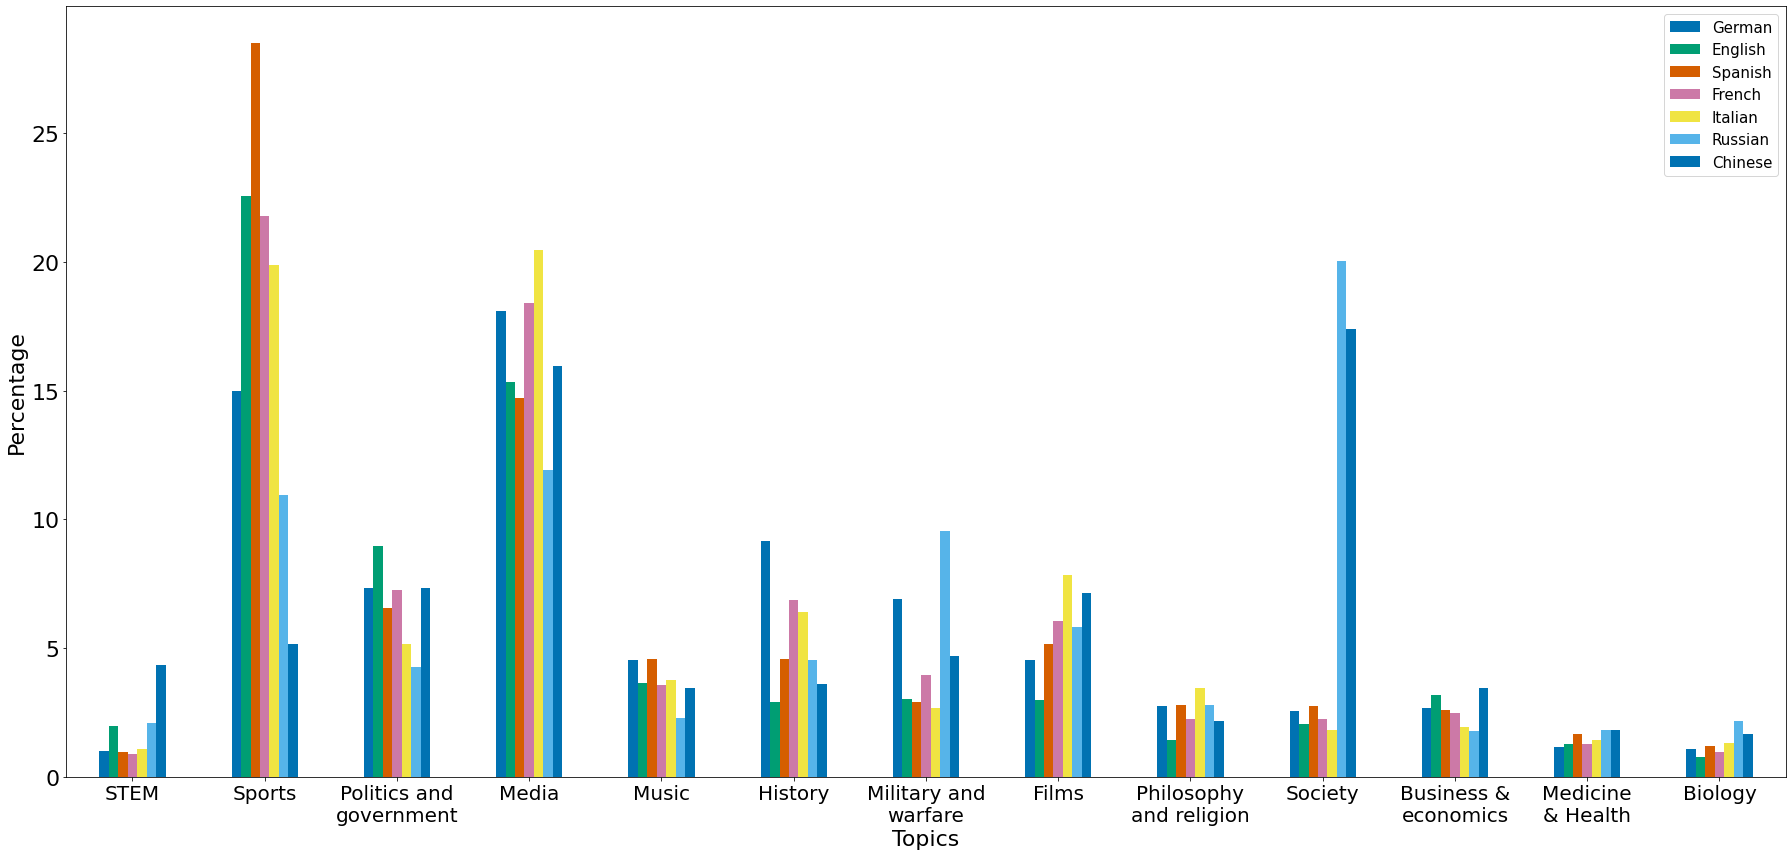

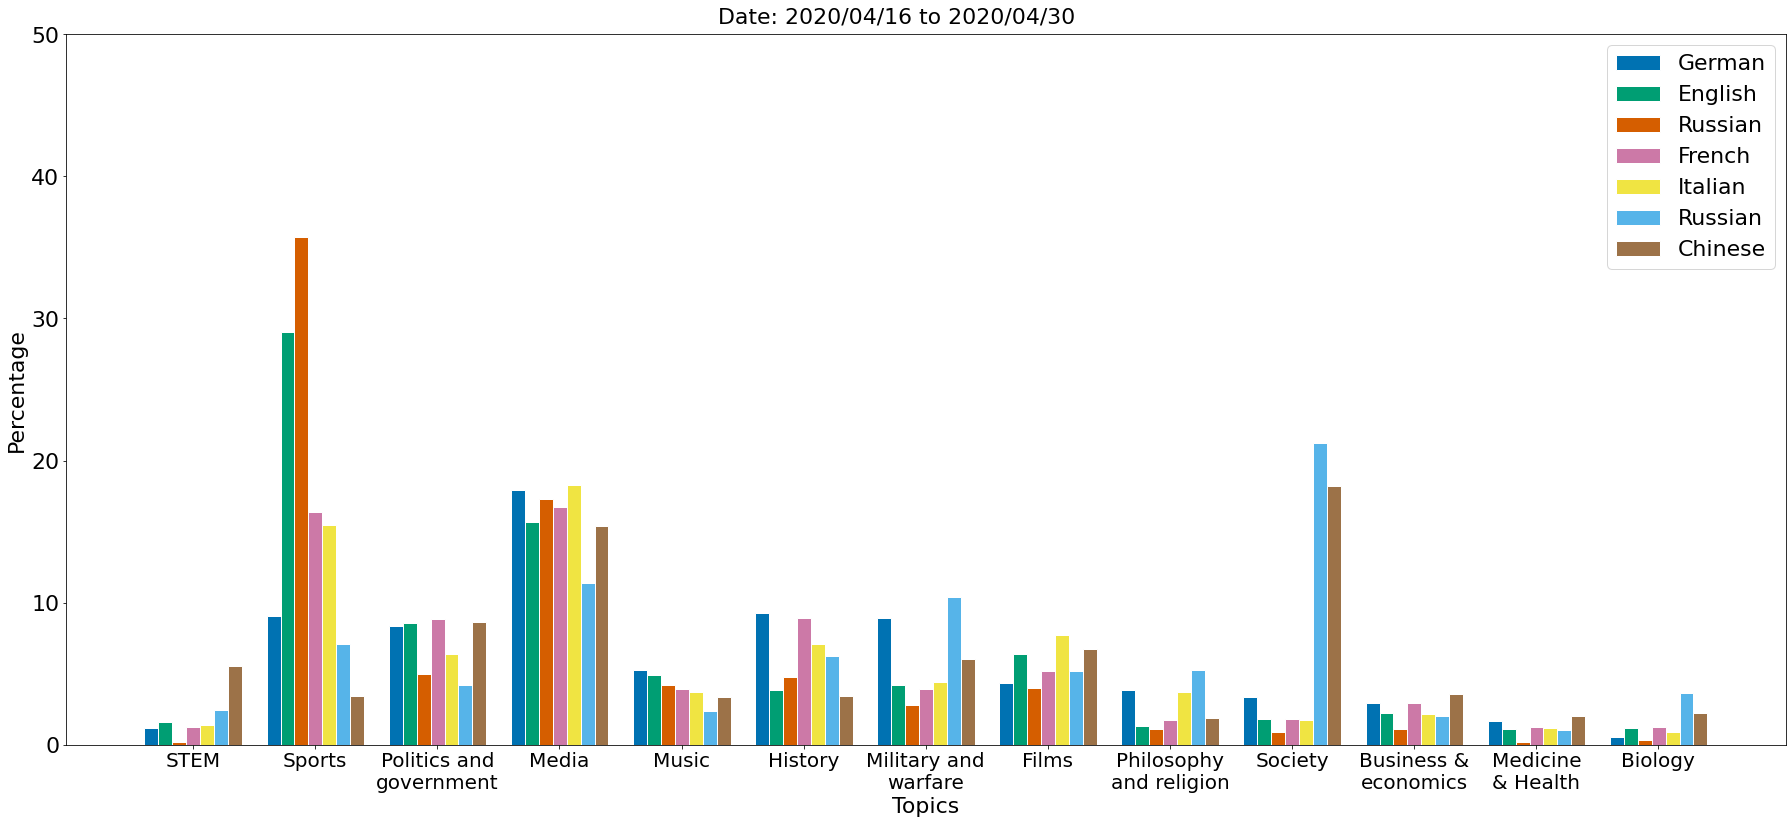

In [21]:
import IPython
import numpy as np
import networkx as nx
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import time
import community
from fonctions import *
from pylab import rcParams
import seaborn as sns
from celluloid import Camera

### Layout parameters
sns.set_palette(palette='colorblind', n_colors=8) 
plt.style.use('seaborn-colorblind')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['figure.figsize'] = 25, 12
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 22

# pd.options.plotting.backend = 'matplotlib'

### Variables for the following pipeline

pd.set_option('mode.chained_assignment', None)

path_de = 'Results/DE/DE_'
path_en = 'Results/EN/EN_'
path_es = 'Results/ES/ES_'
path_fr = 'Results/FR/FR_'
path_it = 'Results/IT/IT_'
path_ru = 'Results/RU/RU_'
path_zh = 'Results/ZH/ZH_'





list_date = ['20191217_20191231', '20200101_20200115', '20200116_20200131', '20200201_20200215',
             '20200216_20200229', '20200301_20200315', '20200316_20200331','20200401_20200415',
             '20200416_20200430']


list_topic = ['STEM*', 'Sports', 'Politics_and_government', 'Media*', 'Music', 'History', 'Military_and_warfare',
             'Films', 'Philosophy_and_religion', 'Society', 'Business_and_economics', 'Medicine_&_Health', 'Biology']




def count_topics(date):
    
    count_de,count_en, count_es,count_fr,count_it,count_ru,count_zh = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    
    df_de = pd.read_csv(path_de + date + '/list_cluster_topic.csv')
    df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
    df_es = pd.read_csv(path_es + date + '/list_cluster_topic.csv')
    df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
    df_it = pd.read_csv(path_it + date + '/list_cluster_topic.csv')
    df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')
    df_zh = pd.read_csv(path_zh + date + '/list_cluster_topic.csv')

    count_de = df_de[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_en = df_en[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_es = df_es[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_fr = df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_it = df_it[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_ru = df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_zh = df_zh[['Subtopic', 'Count']].groupby('Subtopic').sum()

    count_de['Ratio'] = ((count_de['Count'] / count_de['Count'].sum()) * 100)
    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_es['Ratio'] = ((count_es['Count'] / count_es['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_it['Ratio'] = ((count_it['Count'] / count_it['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)
    count_zh['Ratio'] = ((count_zh['Count'] / count_zh['Count'].sum()) * 100)
    
    count_de.sort_values(by="Count", ascending=False, inplace=True)
    count_en.sort_values(by="Count", ascending=False, inplace=True)
    count_es.sort_values(by="Count", ascending=False, inplace=True)
    count_fr.sort_values(by="Count", ascending=False, inplace=True)
    count_it.sort_values(by="Count", ascending=False, inplace=True)
    count_ru.sort_values(by="Count", ascending=False, inplace=True)
    count_zh.sort_values(by="Count", ascending=False, inplace=True)

    return count_de, count_en, count_es, count_fr, count_it, count_ru, count_zh





def count_total_topics(list_date):
    
    count_de,count_en, count_es,count_fr,count_it,count_ru,count_zh = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    
    for date in list_date:
            
        df_de = pd.read_csv(path_de + date + '/list_cluster_topic.csv')
        df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
        df_es = pd.read_csv(path_es + date + '/list_cluster_topic.csv')
        df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
        df_it = pd.read_csv(path_it + date + '/list_cluster_topic.csv')
        df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')
        df_zh = pd.read_csv(path_zh + date + '/list_cluster_topic.csv')
        
        count_de = count_de.add(df_de[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_en = count_en.add(df_en[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_es = count_es.add(df_es[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_fr = count_fr.add(df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)    
        count_it = count_it.add(df_it[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_ru = count_ru.add(df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_zh = count_zh.add(df_zh[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)

    count_de['Ratio'] = ((count_de['Count'] / count_de['Count'].sum()) * 100)
    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_es['Ratio'] = ((count_es['Count'] / count_es['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_it['Ratio'] = ((count_it['Count'] / count_it['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)
    count_zh['Ratio'] = ((count_zh['Count'] / count_zh['Count'].sum()) * 100)
    
    count_de.sort_values(by="Count", ascending=False, inplace=True)
    count_en.sort_values(by="Count", ascending=False, inplace=True)
    count_es.sort_values(by="Count", ascending=False, inplace=True)
    count_fr.sort_values(by="Count", ascending=False, inplace=True)
    count_it.sort_values(by="Count", ascending=False, inplace=True)
    count_ru.sort_values(by="Count", ascending=False, inplace=True)
    count_zh.sort_values(by="Count", ascending=False, inplace=True)

    return count_de, count_en, count_es, count_fr, count_it, count_ru, count_zh
    

    

def display_topics_comparison(ratio_de, ratio_en, ratio_es, ratio_fr, ratio_it, ratio_ru, ratio_zh, list_topic):
    fig = plt.figure()

    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh = [], [], [], [], [], [], []

    for tp in list_topic:
        bars_de.append(list(ratio_de.loc[ratio_de.index.str.contains(tp)])[0])
        bars_en.append(list(ratio_en.loc[ratio_en.index.str.contains(tp)])[0])
        bars_es.append(list(ratio_es.loc[ratio_es.index.str.contains(tp)])[0])
        bars_fr.append(list(ratio_fr.loc[ratio_fr.index.str.contains(tp)])[0])
        bars_it.append(list(ratio_it.loc[ratio_it.index.str.contains(tp)])[0])
        bars_ru.append(list(ratio_ru.loc[ratio_ru.index.str.contains(tp)])[0])
        bars_zh.append(list(ratio_zh.loc[ratio_zh.index.str.contains(tp)])[0])

    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
    l_topic[2]=l_topic[2][0:12] + '\n' + l_topic[2][13:]
    l_topic[6]=l_topic[6][0:12] + '\n' + l_topic[6][13:]
    l_topic[8]=l_topic[8][0:10] + '\n' + l_topic[8][11:]
    l_topic[10]=l_topic[10][0:9] +'&'+ '\n' + l_topic[10][13:]
    l_topic[11]=l_topic[11][0:8] + '\n' + l_topic[11][9:]
    
    plotdata = pd.DataFrame({"German":bars_de,"English":bars_en,"Spanish":bars_es,"French":bars_fr,
                             "Italian":bars_it,"Russian":bars_ru,"Chinese":bars_zh,}, index=l_topic)
    pd_plot = plotdata.plot(kind="bar", rot=0)
    fig = pd_plot.get_figure()
    
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    
    
    fig.tight_layout()
    # Create legend & Show graphic
    plt.legend(fontsize=15)
    plt.show()
    fig.savefig("Figures_comparison/topic_distribution_2.png", bbox_inches='tight')
    
    
    return bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh
    

def barlist(n): 
    bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh = [], [], [], [], [], [], []
    df_de, df_en, df_es, df_fr, df_it, df_ru, df_zh = count_topics(list_date[n])
    for tp in list_topic:
        try:
            bars_de.append(list(df_de.loc[df_de.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_de.append(0)
        try:
            bars_en.append(list(df_en.loc[df_en.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_en.append(0)
        try:
            bars_es.append(list(df_es.loc[df_es.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_es.append(0)
        try:
            bars_fr.append(list(df_fr.loc[df_fr.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_fr.append(0)
        try:
            bars_it.append(list(df_it.loc[df_it.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_it.append(0)
        try:
            bars_ru.append(list(df_ru.loc[df_ru.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_ru.append(0)
        try:
            bars_zh.append(list(df_zh.loc[df_zh.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_zh.append(0)

    return bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh
    
    
    
def topic_evolution(list_topic, list_date):
    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
    l_topic[2]=l_topic[2][0:12] + '\n' + l_topic[2][13:]
    l_topic[6]=l_topic[6][0:12] + '\n' + l_topic[6][13:]
    l_topic[8]=l_topic[8][0:10] + '\n' + l_topic[8][11:]
    l_topic[10]=l_topic[10][0:9] +'&'+ '\n' + l_topic[10][13:]
    l_topic[11]=l_topic[11][0:8] + '\n' + l_topic[11][9:]
    
    # Making date more readable 
    date_title = []
    for date in list_date:
        date_title.append(date[0:4]+'/'+date[4:6]+'/'+date[6:8]+' to '+date[9:13]+'/'+date[13:15]+'/'+date[15:17])
    
    
    
    fig, ax = plt.subplots()
    barWidth = 0.25
    
    
    total_width=0.8
    single_width=1
    n_bars = 7
    bar_width = total_width / n_bars
    x_offset=[]
    for i in range(n_bars):
        x_offset.append((i - n_bars / 2) * bar_width + 2.7*bar_width)
    
    
    ax.set_ylim(0, 50)
    
    n=len(list_date) #Number of frames
    
    bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh = barlist(0)
    
    r = np.arange(len(bars_en))
    r1 = [x + x_offset[0] for x in r]
    r2 = [x + x_offset[1] for x in r]
    r3 = [x + x_offset[2] for x in r]
    r4 = [x + x_offset[3] for x in r]
    r5 = [x + x_offset[4] for x in r]
    r6 = [x + x_offset[5] for x in r]
    r7 = [x + x_offset[6] for x in r]
    
    barcollection_de = plt.bar(r1, bars_de, width=bar_width*single_width, edgecolor='white', label='German', align='center')
    barcollection_en = plt.bar(r2, bars_en, width=bar_width*single_width, edgecolor='white', label='English', align='center')
    barcollection_es = plt.bar(r3, bars_es, width=bar_width*single_width, edgecolor='white', label='Russian', align='center')
    barcollection_fr = plt.bar(r4, bars_fr, width=bar_width*single_width, edgecolor='white', label='French', align='center')
    barcollection_it = plt.bar(r5, bars_it, width=bar_width*single_width, edgecolor='white', label='Italian', align='center')
    barcollection_ru = plt.bar(r6, bars_ru, width=bar_width*single_width, edgecolor='white', label='Russian', align='center')
    barcollection_zh = plt.bar(r7, bars_zh, width=bar_width*single_width, color='#9c7248',edgecolor='white', label='Chinese', align='center')
    
    def animate(i):
        y_de, y_en, y_es, y_fr, y_it, y_ru, y_zh = barlist(i)
        fig.suptitle('Date: ' + date_title[i], fontsize=22)
        for n, b in enumerate(barcollection_de):
            b.set_height(y_de[n])
        for n, b in enumerate(barcollection_en):
            b.set_height(y_en[n])
        for n, b in enumerate(barcollection_es):
            b.set_height(y_es[n])
        for n, b in enumerate(barcollection_fr):
            b.set_height(y_fr[n])
        for n, b in enumerate(barcollection_it):
            b.set_height(y_it[n])
        for n, b in enumerate(barcollection_ru):
            b.set_height(y_ru[n])
        for n, b in enumerate(barcollection_zh):
            b.set_height(y_zh[n])
        
        
        
    anim=FuncAnimation(fig, animate, init_func=None, repeat=True, blit=False, frames=n, interval=1000)
    
    plt.xticks([r + barWidth for r in range(len(list_topic))], l_topic, rotation='horizontal')
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.legend(fontsize=22)
    anim.save('Figures_comparison/bar_2.gif', writer='pillow')
 
    


    
count_de, count_en, count_es, count_fr, count_it, count_ru, count_zh = count_total_topics(list_date)

bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh=display_topics_comparison(count_de['Ratio'],count_en['Ratio'],count_es['Ratio'],count_fr['Ratio'],count_it['Ratio'],count_ru['Ratio'],count_zh['Ratio'],list_topic)

topic_evolution(list_topic, list_date) 

In [14]:
total_count = count_de['Count'].add(count_en['Count'], fill_value=0)
total_count = total_count.add(count_es['Count'], fill_value=0)
total_count = total_count.add(count_fr['Count'], fill_value=0)
total_count = total_count.add(count_it['Count'], fill_value=0)
total_count = total_count.add(count_ru['Count'], fill_value=0)
total_count = total_count.add(count_zh['Count'], fill_value=0)

                              
print("Topics by popularity")                          
total_count.sort_values(ascending=False)

Topics by popularity


Subtopic
Sports                     47299.0
Media*                     44791.0
Politics_and_government    18833.0
Society                    18446.0
Films                      14624.0
History                    14255.0
Military_and_warfare       13227.0
Music                       9844.0
North_America               8281.0
Literature                  7571.0
Business_and_economics      7159.0
Philosophy_and_religion     6583.0
Television                  6459.0
Transportation              5812.0
STEM*                       5010.0
Visual_arts*                4935.0
Medicine_&_Health           3955.0
Biology                     3490.0
Performing_arts             2954.0
Europe*                     2162.0
Technology                  1974.0
Engineering                 1953.0
Earth_and_environment       1889.0
Education                   1857.0
Linguistics                 1854.0
Western_Europe              1764.0
Southern_Europe             1625.0
Architecture                1549.0
Space      

<Figure size 1800x864 with 0 Axes>

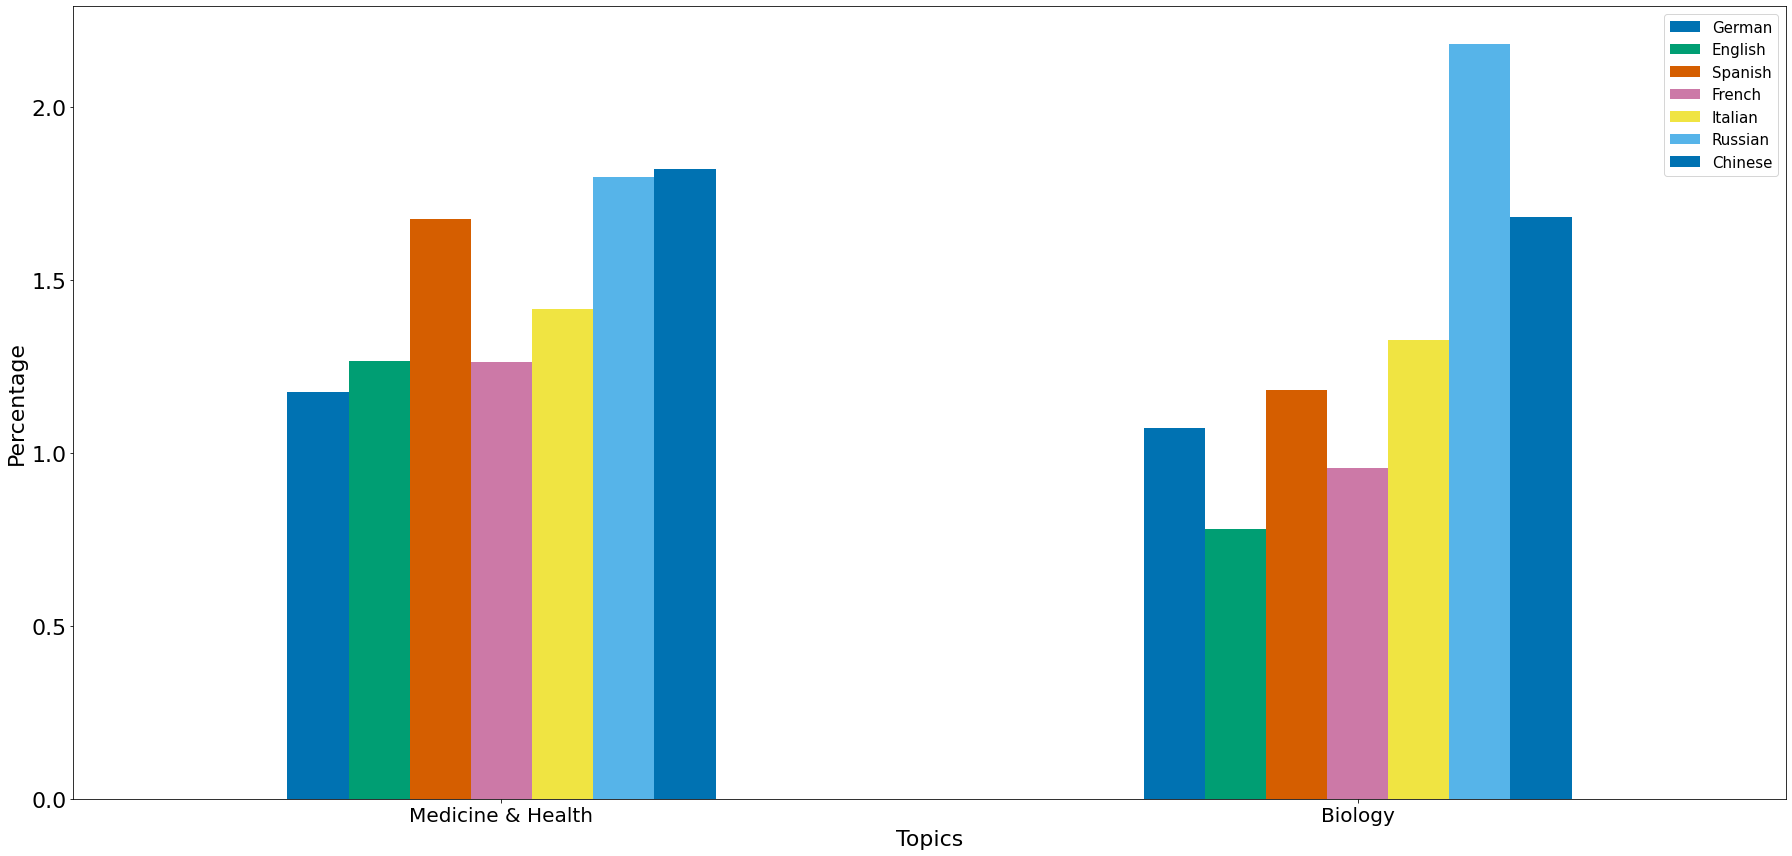

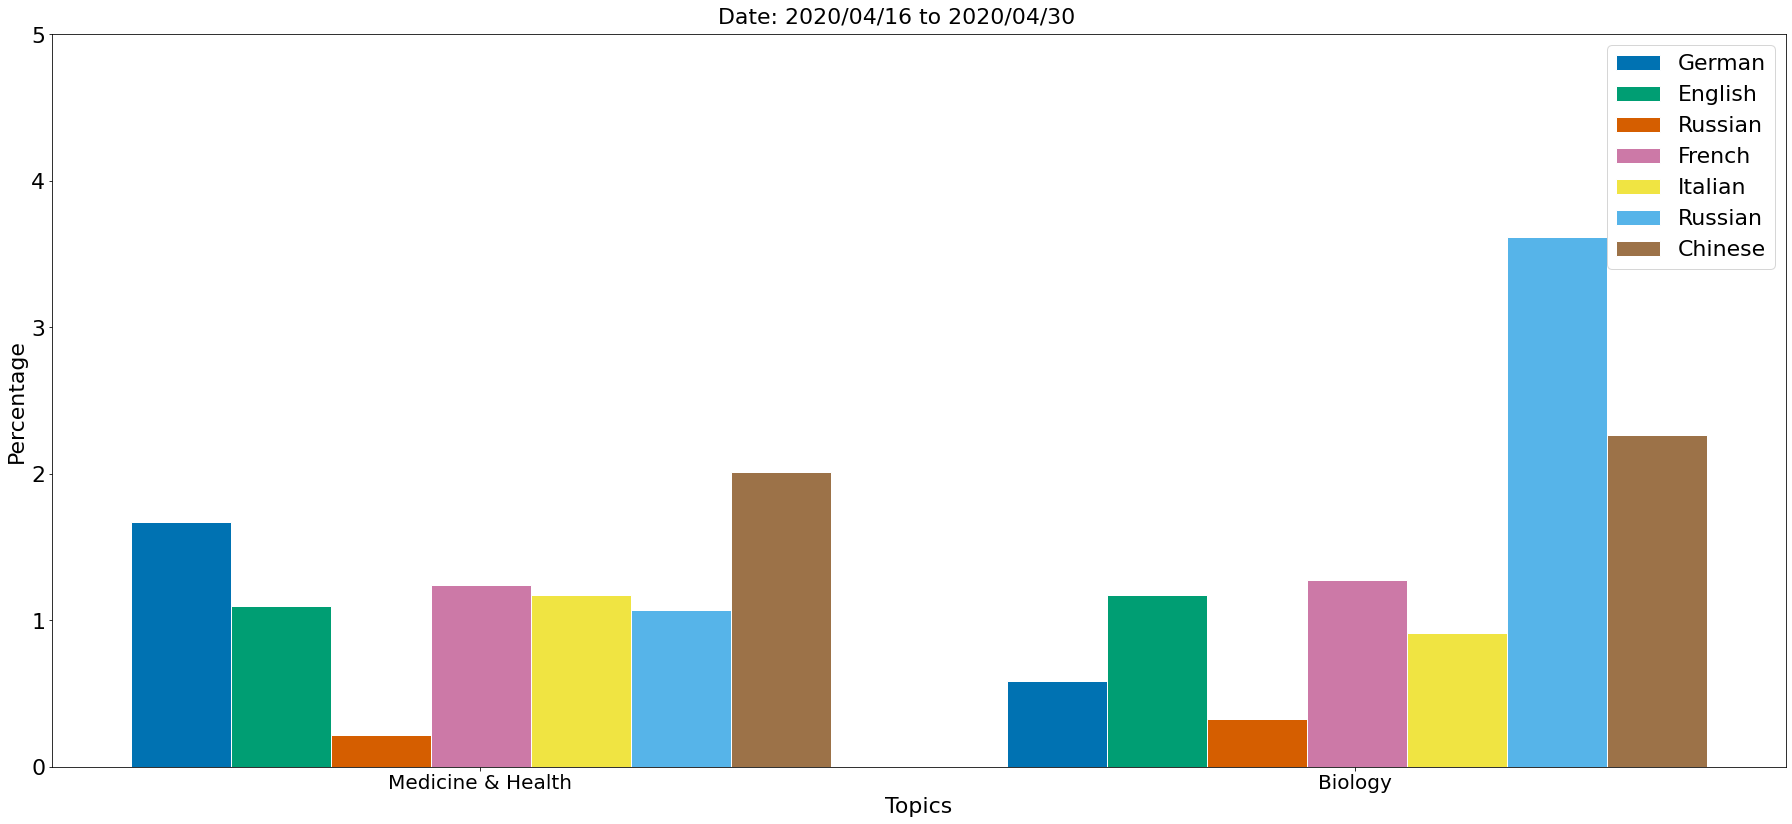

In [22]:
import IPython
import numpy as np
import networkx as nx
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import time
import community
from fonctions import *
from pylab import rcParams
import seaborn as sns
from celluloid import Camera

### Layout parameters
sns.set_palette(palette='colorblind', n_colors=8) 
plt.style.use('seaborn-colorblind')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['figure.figsize'] = 25, 12
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 22

# pd.options.plotting.backend = 'matplotlib'

### Variables for the following pipeline

pd.set_option('mode.chained_assignment', None)

path_de = 'Results/DE/DE_'
path_en = 'Results/EN/EN_'
path_es = 'Results/ES/ES_'
path_fr = 'Results/FR/FR_'
path_it = 'Results/IT/IT_'
path_ru = 'Results/RU/RU_'
path_zh = 'Results/ZH/ZH_'





list_date = ['20191217_20191231', '20200101_20200115', '20200116_20200131', '20200201_20200215',
             '20200216_20200229', '20200301_20200315', '20200316_20200331','20200401_20200415',
             '20200416_20200430']


list_topic = ['Medicine_&_Health', 'Biology']




def count_topics(date):
    
    count_de,count_en, count_es,count_fr,count_it,count_ru,count_zh = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    
    df_de = pd.read_csv(path_de + date + '/list_cluster_topic.csv')
    df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
    df_es = pd.read_csv(path_es + date + '/list_cluster_topic.csv')
    df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
    df_it = pd.read_csv(path_it + date + '/list_cluster_topic.csv')
    df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')
    df_zh = pd.read_csv(path_zh + date + '/list_cluster_topic.csv')

    count_de = df_de[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_en = df_en[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_es = df_es[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_fr = df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_it = df_it[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_ru = df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_zh = df_zh[['Subtopic', 'Count']].groupby('Subtopic').sum()

    count_de['Ratio'] = ((count_de['Count'] / count_de['Count'].sum()) * 100)
    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_es['Ratio'] = ((count_es['Count'] / count_es['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_it['Ratio'] = ((count_it['Count'] / count_it['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)
    count_zh['Ratio'] = ((count_zh['Count'] / count_zh['Count'].sum()) * 100)
    
    count_de.sort_values(by="Count", ascending=False, inplace=True)
    count_en.sort_values(by="Count", ascending=False, inplace=True)
    count_es.sort_values(by="Count", ascending=False, inplace=True)
    count_fr.sort_values(by="Count", ascending=False, inplace=True)
    count_it.sort_values(by="Count", ascending=False, inplace=True)
    count_ru.sort_values(by="Count", ascending=False, inplace=True)
    count_zh.sort_values(by="Count", ascending=False, inplace=True)

    return count_de, count_en, count_es, count_fr, count_it, count_ru, count_zh





def count_total_topics(list_date):
    
    count_de,count_en, count_es,count_fr,count_it,count_ru,count_zh = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    
    for date in list_date:
            
        df_de = pd.read_csv(path_de + date + '/list_cluster_topic.csv')
        df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
        df_es = pd.read_csv(path_es + date + '/list_cluster_topic.csv')
        df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
        df_it = pd.read_csv(path_it + date + '/list_cluster_topic.csv')
        df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')
        df_zh = pd.read_csv(path_zh + date + '/list_cluster_topic.csv')
        
        count_de = count_de.add(df_de[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_en = count_en.add(df_en[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_es = count_es.add(df_es[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_fr = count_fr.add(df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)    
        count_it = count_it.add(df_it[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_ru = count_ru.add(df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_zh = count_zh.add(df_zh[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)

    count_de['Ratio'] = ((count_de['Count'] / count_de['Count'].sum()) * 100)
    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_es['Ratio'] = ((count_es['Count'] / count_es['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_it['Ratio'] = ((count_it['Count'] / count_it['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)
    count_zh['Ratio'] = ((count_zh['Count'] / count_zh['Count'].sum()) * 100)
    
    count_de.sort_values(by="Count", ascending=False, inplace=True)
    count_en.sort_values(by="Count", ascending=False, inplace=True)
    count_es.sort_values(by="Count", ascending=False, inplace=True)
    count_fr.sort_values(by="Count", ascending=False, inplace=True)
    count_it.sort_values(by="Count", ascending=False, inplace=True)
    count_ru.sort_values(by="Count", ascending=False, inplace=True)
    count_zh.sort_values(by="Count", ascending=False, inplace=True)

    return count_de, count_en, count_es, count_fr, count_it, count_ru, count_zh
    

    

def display_topics_comparison(ratio_de, ratio_en, ratio_es, ratio_fr, ratio_it, ratio_ru, ratio_zh, list_topic):
    fig = plt.figure()

    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh = [], [], [], [], [], [], []

    for tp in list_topic:
        bars_de.append(list(ratio_de.loc[ratio_de.index.str.contains(tp)])[0])
        bars_en.append(list(ratio_en.loc[ratio_en.index.str.contains(tp)])[0])
        bars_es.append(list(ratio_es.loc[ratio_es.index.str.contains(tp)])[0])
        bars_fr.append(list(ratio_fr.loc[ratio_fr.index.str.contains(tp)])[0])
        bars_it.append(list(ratio_it.loc[ratio_it.index.str.contains(tp)])[0])
        bars_ru.append(list(ratio_ru.loc[ratio_ru.index.str.contains(tp)])[0])
        bars_zh.append(list(ratio_zh.loc[ratio_zh.index.str.contains(tp)])[0])

    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
    
    plotdata = pd.DataFrame({"German":bars_de,"English":bars_en,"Spanish":bars_es,"French":bars_fr,
                             "Italian":bars_it,"Russian":bars_ru,"Chinese":bars_zh,}, index=l_topic)
    pd_plot = plotdata.plot(kind="bar", rot=0)
    fig = pd_plot.get_figure()
    
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    
    
    fig.tight_layout()
    # Create legend & Show graphic
    plt.legend(fontsize=15)
    plt.show()
    fig.savefig("Figures_comparison/topic_distribution_medicine.png", bbox_inches='tight')
    
    
    return bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh
    

def barlist(n): 
    bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh = [], [], [], [], [], [], []
    df_de, df_en, df_es, df_fr, df_it, df_ru, df_zh = count_topics(list_date[n])
    for tp in list_topic:
        try:
            bars_de.append(list(df_de.loc[df_de.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_de.append(0)
        try:
            bars_en.append(list(df_en.loc[df_en.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_en.append(0)
        try:
            bars_es.append(list(df_es.loc[df_es.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_es.append(0)
        try:
            bars_fr.append(list(df_fr.loc[df_fr.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_fr.append(0)
        try:
            bars_it.append(list(df_it.loc[df_it.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_it.append(0)
        try:
            bars_ru.append(list(df_ru.loc[df_ru.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_ru.append(0)
        try:
            bars_zh.append(list(df_zh.loc[df_zh.index.str.contains(tp), 'Ratio'].values)[0])
        except (IndexError):
            bars_zh.append(0)

    return bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh
    
    
    
def topic_evolution(list_topic, list_date):
    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
  
    
    # Making date more readable 
    date_title = []
    for date in list_date:
        date_title.append(date[0:4]+'/'+date[4:6]+'/'+date[6:8]+' to '+date[9:13]+'/'+date[13:15]+'/'+date[15:17])
    
    
    
    fig, ax = plt.subplots()
    barWidth = 0.25
    
    
    total_width=0.8
    single_width=1
    n_bars = 7
    bar_width = total_width / n_bars
    x_offset=[]
    for i in range(n_bars):
        x_offset.append((i - n_bars / 2) * bar_width + 2.7*bar_width)
    
    
    ax.set_ylim(0, 5)
    
    n=len(list_date) #Number of frames
    
    bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh = barlist(0)
    
    r = np.arange(len(bars_en))
    r1 = [x + x_offset[0] for x in r]
    r2 = [x + x_offset[1] for x in r]
    r3 = [x + x_offset[2] for x in r]
    r4 = [x + x_offset[3] for x in r]
    r5 = [x + x_offset[4] for x in r]
    r6 = [x + x_offset[5] for x in r]
    r7 = [x + x_offset[6] for x in r]
    
    barcollection_de = plt.bar(r1, bars_de, width=bar_width*single_width, edgecolor='white', label='German', align='center')
    barcollection_en = plt.bar(r2, bars_en, width=bar_width*single_width, edgecolor='white', label='English', align='center')
    barcollection_es = plt.bar(r3, bars_es, width=bar_width*single_width, edgecolor='white', label='Russian', align='center')
    barcollection_fr = plt.bar(r4, bars_fr, width=bar_width*single_width, edgecolor='white', label='French', align='center')
    barcollection_it = plt.bar(r5, bars_it, width=bar_width*single_width, edgecolor='white', label='Italian', align='center')
    barcollection_ru = plt.bar(r6, bars_ru, width=bar_width*single_width, edgecolor='white', label='Russian', align='center')
    barcollection_zh = plt.bar(r7, bars_zh, width=bar_width*single_width, color='#9c7248',edgecolor='white', label='Chinese', align='center')
    
    def animate(i):
        y_de, y_en, y_es, y_fr, y_it, y_ru, y_zh = barlist(i)
        fig.suptitle('Date: ' + date_title[i], fontsize=22)
        for n, b in enumerate(barcollection_de):
            b.set_height(y_de[n])
        for n, b in enumerate(barcollection_en):
            b.set_height(y_en[n])
        for n, b in enumerate(barcollection_es):
            b.set_height(y_es[n])
        for n, b in enumerate(barcollection_fr):
            b.set_height(y_fr[n])
        for n, b in enumerate(barcollection_it):
            b.set_height(y_it[n])
        for n, b in enumerate(barcollection_ru):
            b.set_height(y_ru[n])
        for n, b in enumerate(barcollection_zh):
            b.set_height(y_zh[n])
        
        
        
    anim=FuncAnimation(fig, animate, init_func=None, repeat=True, blit=False, frames=n, interval=1000)
    
    plt.xticks([r + barWidth for r in range(len(list_topic))], l_topic, rotation='horizontal')
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.legend(fontsize=22)
    anim.save('Figures_comparison/bar_medicine.gif', writer='pillow')
 
    


    
count_de, count_en, count_es, count_fr, count_it, count_ru, count_zh = count_total_topics(list_date)

bars_de, bars_en, bars_es, bars_fr, bars_it, bars_ru, bars_zh=display_topics_comparison(count_de['Ratio'],count_en['Ratio'],count_es['Ratio'],count_fr['Ratio'],count_it['Ratio'],count_ru['Ratio'],count_zh['Ratio'],list_topic)

topic_evolution(list_topic, list_date) 